<a href="https://colab.research.google.com/github/ranjanguddu/Machine-Learning/blob/master/EVA4/Session-12/version-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# let's mount our google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.chdir('/content/drive/My Drive/EVA4_Assignment/Modules/')

In [17]:
! ls -l

total 242339
-rw------- 1 root root      1424 Apr 11 06:22 Albumentation_Process.py
-rw------- 1 root root      2254 Apr 11 05:36 CLR.py
drwx------ 3 root root      4096 Apr 11 05:38 data
-rw------- 1 root root       564 Apr 11 05:45 DataLoaders.py
-rw------- 1 root root       527 Apr 11 05:36 Denorm.py
-rw------- 1 root root      1078 Apr 11 05:36 Display.py
-rw------- 1 root root       764 Apr 11 05:36 Find_Data_Stats.py
-rw------- 1 root root     18977 Apr  3 16:31 LR_Finder.py
drwx------ 4 root root      4096 Mar 21 11:31 models
-rw------- 1 root root      6230 Apr 11 05:36 OneCycle.py
drwx------ 2 root root      4096 Apr 11 05:38 __pycache__
-rw------- 1 root root       900 Apr 15 07:17 Test_the_Model.py
drwx------ 5 root root      4096 Apr 15 06:06 tiny-imagenet-200
-rw------- 1 root root 248100043 Apr 14 11:23 tiny-imagenet-200.zip
-rw------- 1 root root       434 Apr 11 07:48 Traingular_Plot.py
-rw------- 1 root root      1904 Apr 11 07:11 Train_the_Model.py


In [0]:
from zipfile import ZipFile

# Create a ZipFile Object and load sample.zip in it
with ZipFile('tiny-imagenet-200.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

In [0]:
import zipfile
import requests

from io import StringIO, BytesIO
def download_images(url):
  if(os.path.isdir("tiny-imagenet-200.zip")):
    print("Images already downloaded")
    return

  r = requests.get(url, stream=True)
  print('Downloading'+url)

  zip_ref = zipfile.ZipFile(BytesIO(r.content))
  zip_ref.extractall('./')
  zip_ref.close()

In [0]:
url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
download_images(url)

In [0]:
! pip install scipy==1.1.0

In [5]:
import time
import scipy.ndimage as nd
from skimage import io
import numpy as np

path = '/content/drive/My Drive/EVA4_Assignment/tiny-imagenet-200/'

def get_id_dictionary():
    id_dict = {}
    for i, line in enumerate(open( path + 'wnids.txt', 'r')):
        id_dict[line.replace('\n', '')] = i
    return id_dict
  
def get_class_to_id_dict():
    id_dict = get_id_dictionary()
    all_classes = {}
    result = {}
    for i, line in enumerate(open( path + 'words.txt', 'r')):
        n_id, word = line.split('\t')[:2]
        all_classes[n_id] = word
    for key, value in id_dict.items():
        result[value] = (key, all_classes[key])      
    return result

def get_data(id_dict):
    print('starting loading data')
    train_data, test_data = [], []
    train_labels, test_labels = [], []
    t = time.time()
    for key, value in id_dict.items():
        train_data += [nd.imread( path + 'train/{}/images/{}_{}.JPEG'.format(key, key, str(i)), mode='RGB') for i in range(500)]
        train_labels_ = np.array([[0]*200]*500)
        train_labels_[:, value] = 1
        train_labels += train_labels_.tolist()

    for line in open( path + 'val/val_annotations.txt'):
        img_name, class_id = line.split('\t')[:2]
        test_data.append(nd.imread( path + 'val/images/{}'.format(img_name) ,mode='RGB'))
        test_labels_ = np.array([[0]*200])
        test_labels_[0, id_dict[class_id]] = 1
        test_labels += test_labels_.tolist()

    print('finished loading data, in {} seconds'.format(time.time() - t))
    return np.array(train_data), np.array(train_labels), np.array(test_data), np.array(test_labels)
  
train_data, train_labels, test_data, test_labels = get_data(get_id_dictionary())

print( "train data shape: ",  train_data.shape )
print( "train label shape: ", train_labels.shape )
print( "test data shape: ",   test_data.shape )
print( "test_labels.shape: ", test_labels.shape )

starting loading data


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


finished loading data, in 142.0177628993988 seconds
train data shape:  (100000, 64, 64, 3)
train label shape:  (100000, 200)
test data shape:  (10000, 64, 64, 3)
test_labels.shape:  (10000, 200)


In [0]:
import time

import numpy as np
from torchvision import datasets, transforms
import torch
from Denorm import unnormalize

import matplotlib.pyplot as plt
from matplotlib import pyplot
from Albumentation_Process import Albumentations
from Find_Data_Stats import Cal_Mean_STD

from Denorm import unnormalize

import torchvision
import torch.nn as nn
import torch.optim as optim

in the init of Albumentation
Finally Append become:[<albumentations.augmentations.transforms.Rotate object at 0x7f87b6b70550>, <albumentations.augmentations.transforms.Normalize object at 0x7f87b6b70390>, <albumentations.augmentations.transforms.Cutout object at 0x7f87b6b70470>, <albumentations.pytorch.transforms.ToTensor object at 0x7f87b6b70be0>]
tensor([[[-1.6384, -1.1075, -0.4911,  ..., -1.1589, -1.2959, -1.4158],
         [-1.2788, -0.8849, -2.1179,  ..., -1.2103, -1.3130, -1.4158],
         [-0.9363, -0.7308, -1.9467,  ..., -1.2617, -1.2959, -1.3130],
         ...,
         [-2.0665, -2.0494, -2.0494,  ...,  0.3309,  0.1768, -0.2171],
         [-2.0665, -2.0494, -2.0494,  ..., -1.8268, -1.8439, -2.0494],
         [-2.0665, -2.0494, -2.0494,  ..., -2.0152, -1.9980, -1.8953]],

        [[-0.9328, -0.4776,  0.0126,  ..., -1.3354, -1.4755, -1.5805],
         [-0.5476, -0.2500, -1.9657,  ..., -1.3880, -1.4930, -1.5805],
         [-0.1975, -0.0399, -1.4055,  ..., -1.4405, -1.4930, -1.4

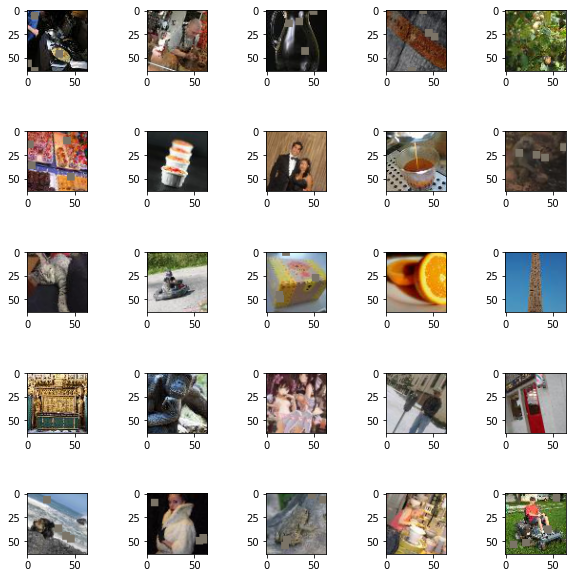

In [4]:
from torchvision.datasets import ImageFolder

mean,std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
norm_mean_std=[mean,std]
train = "/content/drive/My Drive/EVA4_Assignment/tiny-imagenet-200/train"
#val = "/content/drive/My Drive/EVA4_Assignment/Modules/tiny-imagenet-200/val"

train_transforms = Albumentations(norm_mean_std,Rotate=(-30.0,30.0),cutout=(4,))

training_data = ImageFolder(train, transform=train_transforms)

import DataLoaders
loader = DataLoaders.DataLoader()

# train dataloader
train_loader = loader.load(training_data)

# print few traning images
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(images[0])
print(labels[0])


figure = plt.figure(figsize=(10, 10))
figure.subplots_adjust(hspace=1, wspace=0.5)
for i in range(25):
    im = images[i]
    #im = im.numpy()
                 
    #lab = labels[i]
    plt.subplot(5,5,i+1)
    plt.imshow(unnormalize(mean,std,im))
    #plt.imshow(np.transpose(im, (1,2,0)))
    #plt.title("Label: %s" % labels[0])

plt.show()



In [0]:
mean,std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
norm_mean_std=[mean,std]

In [8]:
data = np.concatenate((train_data,test_data))
labels = np.concatenate((train_labels,test_labels))
label= np.argmax(labels, axis=1)

print(label.shape)
print(data.shape)


(110000,)
(110000, 64, 64, 3)


In [0]:
from torch.utils.data import Dataset
import numpy as np

class TinyImageNet(Dataset):
    def __init__(self, data,labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform
        print("Training Data Shape:{}".format(self.data.shape))
        print("Training Label Shape:{}".format(self.labels.shape))
        
        
    
    def __len__(self):
        len_data = self.data.shape[0]
        return len_data
    
    def __getitem__(self, index):
        image = self.data[index]
        #image_tensor = torch.FloatTensor(image)
        #img =torch.from_numpy(image).permute(2,1,0)
        #img_tensor = torch.FloatTensor(img)
        
        #print("sape of image is:{}".format(img.shape))
        
        y_label = self.labels[index]
        
        if self.transform:
            image = self.transform(image)
            #img =torch.from_numpy(image).permute(2,1,0)
            
            
            
        
        
        return image, y_label
 

In [10]:
train_transforms = Albumentations(norm_mean_std,Rotate=(-30.0,30.0),cutout=(4,))
#test_transforms = Albumentations(norm_mean_std)

test_transforms = transforms.Compose([transforms.ToPILImage(),
                                      transforms.ToTensor(),
                                      
                                      ])

in the init of Albumentation
Finally Append become:[<albumentations.augmentations.transforms.Rotate object at 0x7fb09faaaba8>, <albumentations.augmentations.transforms.Normalize object at 0x7fb09faaabe0>, <albumentations.augmentations.transforms.Cutout object at 0x7fb09faaac18>, <albumentations.pytorch.transforms.ToTensor object at 0x7fb09faaac50>]


In [11]:
training_data = TinyImageNet(data[0:77000, :], label[0:77000],transform=train_transforms)
testing_data = TinyImageNet(data[77000:110000, :], label[77000:110000], transform=test_transforms)

Training Data Shape:(77000, 64, 64, 3)
Training Label Shape:(77000,)
Training Data Shape:(33000, 64, 64, 3)
Training Label Shape:(33000,)


In [0]:
from torch.utils.data import DataLoader

tain_loader = DataLoader(dataset= traininig_data, batch_size=128, shuffle=True)
test_loader = DataLoader(dataset= traininig_data, batch_size=128, shuffle=False)

In [0]:
import DataLoaders
loader = DataLoaders.DataLoader()

# train dataloader
train_loader = loader.load(training_data)

# test dataloader
test_loader = loader.load(testing_data)

In [18]:
print(len(train_loader))

151


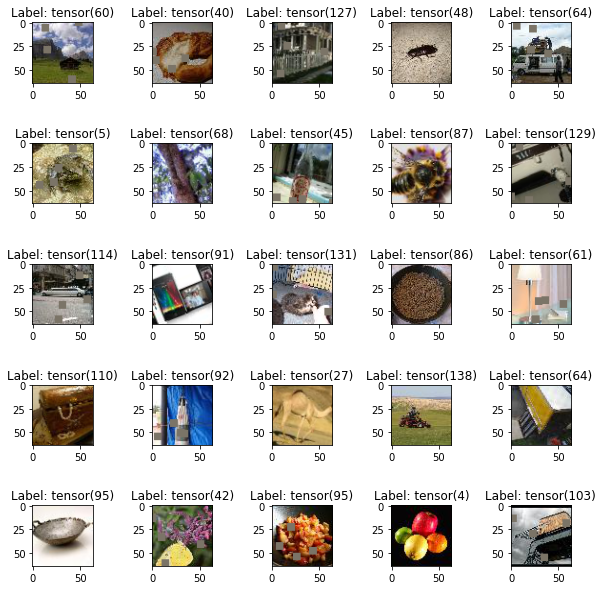

In [13]:
# print few traning images
dataiter = iter(train_loader)
images, labels = dataiter.next()
##print(images[0])
#print(images.shape)

#print(labels[0])
#l= np.argmax(labels[0])


figure = plt.figure(figsize=(10, 10))
figure.subplots_adjust(hspace=1, wspace=0.5)
for i in range(25):
    im = images[i]
    #im = im.numpy()
                 
    lab = labels[i]
    plt.subplot(5,5,i+1)
    plt.imshow(unnormalize(mean,std,im))
    #plt.imshow(np.transpose(im, (1,2,0)))
    plt.title("Label: %s" % lab)

plt.show()


In [0]:
# print few traning images
testiter = iter(test_loader)
images, labels = testiter.next()

torch.Size([3, 64, 64])
tensor(159)


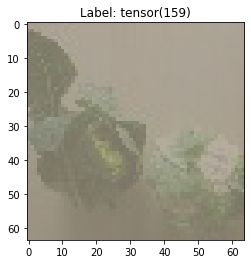

In [29]:
print(images[0].shape)
print(labels[0])

plt.imshow(unnormalize(mean, std, im))
plt.title("Label: %s" % labels[0])
plt.show()


tensor([[[0.1804, 0.1843, 0.1490,  ..., 0.1216, 0.7412, 0.8980],
         [0.1882, 0.1843, 0.1765,  ..., 0.0941, 0.8157, 0.8863],
         [0.2039, 0.1882, 0.2039,  ..., 0.1569, 0.9137, 0.8980],
         ...,
         [0.4549, 0.5647, 0.5176,  ..., 0.8627, 0.8902, 0.8784],
         [0.6235, 0.4118, 0.3804,  ..., 0.9020, 0.8275, 0.8745],
         [0.1647, 0.5176, 0.5451,  ..., 0.8431, 0.9451, 0.8235]],

        [[0.1176, 0.1216, 0.0863,  ..., 0.0275, 0.6510, 0.8078],
         [0.1255, 0.1216, 0.1137,  ..., 0.0118, 0.7216, 0.7961],
         [0.1412, 0.1255, 0.1412,  ..., 0.0745, 0.8314, 0.8157],
         ...,
         [0.4510, 0.5686, 0.5216,  ..., 0.8627, 0.8941, 0.8902],
         [0.6275, 0.4157, 0.3843,  ..., 0.9059, 0.8392, 0.8941],
         [0.1686, 0.5216, 0.5412,  ..., 0.8471, 0.9647, 0.8510]],

        [[0.0667, 0.0706, 0.0353,  ..., 0.0000, 0.5294, 0.6863],
         [0.0745, 0.0706, 0.0627,  ..., 0.0000, 0.6118, 0.6745],
         [0.0902, 0.0745, 0.0824,  ..., 0.0000, 0.7176, 0.

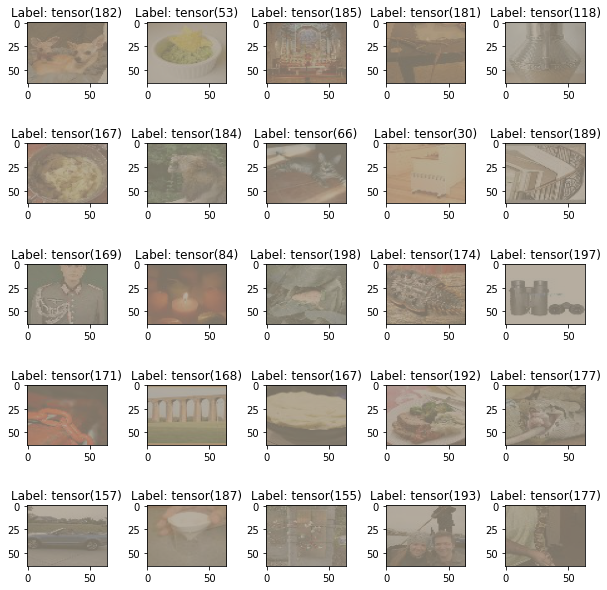

In [15]:
# print few traning images
testiter = iter(test_loader)
images, labels = testiter.next()

print(images[0])
#print(labels[0])

figure = plt.figure(figsize=(10, 10))
figure.subplots_adjust(hspace=1, wspace=0.5)
for i in range(25):
    im = images[i]
    lab = labels[i]
    plt.subplot(5,5,i+1)
    plt.imshow(unnormalize(mean, std, im), aspect='auto')
    #plt.imshow(np.transpose(im, (1,2,0)))
    plt.title("Label: %s" % labels[i])

plt.show()

In [16]:
from models.ResNet18_for_64 import ResNet18
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = ResNet18().to(device)
summary(model, input_size=(3, 64, 64))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           9,408
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          36,864
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
       BasicBlock-11           [-1, 64, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          36,864
      BatchNorm2d-13           [-1, 64, 16, 16]             128
             ReLU-14           [-1

In [15]:
print(len(test_loader.dataset))

33000


In [0]:
from tqdm import tqdm
from torch.autograd import Variable



def train(model, device, train_loader, criterion, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  avg_loss = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples

    #print("input image shape:{}. input label shape:{}".format(data.shape, target.shape))
    
    #print("input image type:{}. input label type:{}".format(type(data),type(target) ))
    #print(data[0])
    data = data.to(device=device)
    target = target.to( device=device)


    
    #print("after .to(device)")
    #print("input image shape:{}. input label shape:{}".format(data.shape, target.shape))
    #print(data[0])
    #print("input image type:{}. input label type:{}".format(type(data),type(target) ))

    #break
    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    

    loss = criterion(y_pred, target)

    # Calculate loss
    #loss = criterion(y_pred, target)
   

    # Backpropagation
    loss.backward()
    optimizer.step()
    #if scheduler:
      #scheduler.step()

    # Update pbar-tqdm
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)
    avg_loss += loss.item()

    #pbar_str = f'Training Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}'
    pbar_str = f'Training Loss={loss.item()}  Accuracy={100*correct/processed:0.2f}'

    

    pbar.set_description(desc= pbar_str)


def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    #test_losses=[]
    #test_accs=[]
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device=device), target.to(device=device)
            output = model(data)
            test_loss +=criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            is_correct = pred.eq(target.view_as(pred))
            
            correct += is_correct.sum().item()

    test_loss /= len(test_loader.dataset)
    #test_losses.append(test_loss)
    
    test_acc = 100. * correct / len(test_loader.dataset)
    #test_accs.append(test_acc)

    

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), test_acc))

In [22]:
#from Train_the_Model import train
#from Test_the_Model import test
from torch.optim.lr_scheduler import ReduceLROnPlateau
from OneCycle import OneCycle
import time



Epochs = 50
bs = 512
lr=0.005065322958572848


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay = 1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=3, verbose=True, min_lr=1e-5)



lr_trend = []
def run():
  l1_decay = 0
  l2_decay = 0

  test_losses = []
  test_accs = []
  train_losses = []
  train_accs = []
  misclassified_imgs = []
  correct_imgs = []
  use_cycle = True
  print("\n")
  for epoch in range(Epochs):
      lr_trend.append(optimizer.param_groups[0]['lr'])
      print(f"EPOCH: {epoch+1} (LR: {lr_trend[-1]:0.6f})")
      t0=time.time()
      print("EPOCH:", epoch+1)
      

      train(model, device,train_loader, criterion, optimizer, epoch)
      test(model, device, test_loader, criterion)

      #scheduler.step(test_losses[-1])
      t1= time.time()
      print("Time taken in epoch {} is {:.2f} Seconds\n".format(epoch+1, (t1-t0)))
  #return train_losses, train_accs, test_losses, test_accs

# train and test the model
#train_losses, train_accs, test_losses, test_accs = 
run()


  0%|          | 0/151 [00:00<?, ?it/s]



EPOCH: 1 (LR: 0.005065)
EPOCH: 1


  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0179, Accuracy: 91/33000 (0.28%)

Time taken in epoch 1 is 47.86 Seconds

EPOCH: 2 (LR: 0.005065)
EPOCH: 2


  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0189, Accuracy: 94/33000 (0.28%)

Time taken in epoch 2 is 47.43 Seconds

EPOCH: 3 (LR: 0.005065)
EPOCH: 3


  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0195, Accuracy: 95/33000 (0.29%)

Time taken in epoch 3 is 47.35 Seconds

EPOCH: 4 (LR: 0.005065)
EPOCH: 4


  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0201, Accuracy: 99/33000 (0.30%)

Time taken in epoch 4 is 47.47 Seconds

EPOCH: 5 (LR: 0.005065)
EPOCH: 5


  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0200, Accuracy: 118/33000 (0.36%)

Time taken in epoch 5 is 47.39 Seconds

EPOCH: 6 (LR: 0.005065)
EPOCH: 6


  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0195, Accuracy: 117/33000 (0.35%)

Time taken in epoch 6 is 47.31 Seconds

EPOCH: 7 (LR: 0.005065)
EPOCH: 7


  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0202, Accuracy: 155/33000 (0.47%)

Time taken in epoch 7 is 47.64 Seconds

EPOCH: 8 (LR: 0.005065)
EPOCH: 8


  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0208, Accuracy: 112/33000 (0.34%)

Time taken in epoch 8 is 47.54 Seconds

EPOCH: 9 (LR: 0.005065)
EPOCH: 9


  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0206, Accuracy: 171/33000 (0.52%)

Time taken in epoch 9 is 47.38 Seconds

EPOCH: 10 (LR: 0.005065)
EPOCH: 10


  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0209, Accuracy: 147/33000 (0.45%)

Time taken in epoch 10 is 47.41 Seconds

EPOCH: 11 (LR: 0.005065)
EPOCH: 11


  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0211, Accuracy: 160/33000 (0.48%)

Time taken in epoch 11 is 47.50 Seconds

EPOCH: 12 (LR: 0.005065)
EPOCH: 12


  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0207, Accuracy: 169/33000 (0.51%)

Time taken in epoch 12 is 47.57 Seconds

EPOCH: 13 (LR: 0.005065)
EPOCH: 13


  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0209, Accuracy: 180/33000 (0.55%)

Time taken in epoch 13 is 47.61 Seconds

EPOCH: 14 (LR: 0.005065)
EPOCH: 14


  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0211, Accuracy: 188/33000 (0.57%)

Time taken in epoch 14 is 47.58 Seconds

EPOCH: 15 (LR: 0.005065)
EPOCH: 15


  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0218, Accuracy: 186/33000 (0.56%)

Time taken in epoch 15 is 47.61 Seconds

EPOCH: 16 (LR: 0.005065)
EPOCH: 16


  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0224, Accuracy: 121/33000 (0.37%)

Time taken in epoch 16 is 47.81 Seconds

EPOCH: 17 (LR: 0.005065)
EPOCH: 17


  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0212, Accuracy: 164/33000 (0.50%)

Time taken in epoch 17 is 47.66 Seconds

EPOCH: 18 (LR: 0.005065)
EPOCH: 18


  0%|          | 0/151 [00:00<?, ?it/s]

Test set: Average loss: 0.0206, Accuracy: 183/33000 (0.55%)

Time taken in epoch 18 is 47.72 Seconds

EPOCH: 19 (LR: 0.005065)
EPOCH: 19


Training Loss=1.9026905298233032  Accuracy=54.33:  99%|█████████▊| 149/151 [00:41<00:00,  3.77it/s]

KeyboardInterrupt: ignored